# 以 Q-learning 求解 CliffWalking

In [1]:
# 匯入zipfile模組，用來處理.zip壓縮檔案
import zipfile

# 使用with敘述開啟lib.zip壓縮檔案，確保使用完自動關閉
with zipfile.ZipFile("lib.zip") as zf:
    # 使用infolist()取得壓縮檔中所有檔案的資訊(ZipInfo物件)
    for info in zf.infolist():
    
        # 因為某些zip壓縮檔的檔名是以cp437編碼(特別是從Windows系統壓縮的)
        # 所以這裡先將原本的檔名(字串)用cp437編碼為bytes，再用utf-8解碼為正確的字串
        # 這樣可以正確顯示中文或特殊字元的檔名
        print(info.filename.encode('cp437').decode('utf-8'))

        # 將目前這個檔案(info)解壓縮到target_folder資料夾中
        zf.extract(info, "target_folder")

lib/__init__.py
lib/__pycache__/
lib/__pycache__/__init__.cpython-38.pyc
lib/__pycache__/__init__.cpython-39.pyc
lib/__pycache__/plotting.cpython-38.pyc
lib/__pycache__/plotting.cpython-39.pyc
lib/atari/
lib/atari/__init__.py
lib/atari/helpers.py
lib/atari/state_processor.py
lib/envs/
lib/envs/.ipynb_checkpoints/
lib/envs/.ipynb_checkpoints/gridworld-checkpoint.py
lib/envs/__init__.py
lib/envs/__pycache__/
lib/envs/__pycache__/__init__.cpython-36.pyc
lib/envs/__pycache__/__init__.cpython-38.pyc
lib/envs/__pycache__/__init__.cpython-39.pyc
lib/envs/__pycache__/blackjack.cpython-38.pyc
lib/envs/__pycache__/blackjack.cpython-39.pyc
lib/envs/__pycache__/cliff_walking.cpython-36.pyc
lib/envs/__pycache__/cliff_walking.cpython-38.pyc
lib/envs/__pycache__/cliff_walking.cpython-39.pyc
lib/envs/__pycache__/discrete.cpython-38.pyc
lib/envs/__pycache__/discrete.cpython-39.pyc
lib/envs/__pycache__/gridworld.cpython-38.pyc
lib/envs/__pycache__/gridworld.cpython-39.pyc
lib/envs/__pycache__/gridworld0

In [2]:
# 匯入itertools模組，用於高效迭代工具
import itertools

# 匯入matplotlib套件，用於資料視覺化
import matplotlib

# 匯入numpy套件，用於數值計算與陣列處理
import numpy as np

# 匯入random模組，用於隨機數生成
import random

# 匯入sys模組，用於與系統互動
import sys

# 匯入os模組，用於與作業系統互動
import os

# 將指定路徑加入系統模組搜尋路徑中，這樣可以匯入該路徑下的自訂模組
sys.path.append(os.path.abspath("E:/Colab第三階段202505/ch21_20250828/reinforcement-learning"))

# 從collections模組匯入defaultdict，用於建立帶有預設值的字典
from collections import defaultdict

# 從lib.agents.td_agent模組匯入TDAgent類別，這是一個時間差分學習代理
from lib import plotting

# 匯入gymnasium套件，用於建立和操作強化學習環境
import gymnasium as gym

In [3]:
# 建立CliffWalking-v1環境，這是一個經典的強化學習問題
# 地圖大小固定為4x12，智能體需從起點走到終點，途中避免掉入懸崖(cliff)
# 動作是確定性的(無隨機性)，每一步的回饋根據位置而定
env = gym.make('CliffWalking-v1')

In [4]:
# 定義貪婪(greedy)策略函數，用於根據Q值選擇報酬最高的行動
# Q：是一個狀態-行動價值函數(dict或array)，Q[s][a]表示在狀態s採取動作a的期望報酬
# epsilon：探索率，代表有epsilon的機率隨機選擇動作，(1 - epsilon)的機率採用貪婪行動
# nA：每個狀態下的動作總數

def make_epsilon_greedy_policy(Q, epsilon, nA):
    # 傳回一個策略函數：輸入狀態(observation)，輸出每個動作的機率分布
    def policy_fn(observation):
        # 初始化一個長度為nA的陣列，所有動作機率初始為epsilon / nA(代表均勻探索)
        A = np.ones(nA, dtype = float) * epsilon / nA

        # 找出在當前狀態下，Q值最高的動作(最佳動作)
        best_action = np.argmax(Q[observation])

        # 將最佳動作的機率增加(1 - epsilon)，組成epsilon-greedy策略
        A[best_action] += (1.0 - epsilon)

        # 傳回這個動作機率分布(是一個ndarray一維陣列)
        return A
    
    # 傳回產生的策略函數(可以用於選擇行動)
    return policy_fn

In [5]:
# 定義一個Q-Learning函式
# env：環境物件
# num_episodes：執行的回合數(預設1000)
# discount_factor：折扣因子γ，控制未來獎勵重要性(預設0.9)
# alpha：學習率，控制Q值更新幅度(預設0.5)
# epsilon：探索率，代表有epsilon的機率隨機選擇動作，(1 - epsilon)的機率採用貪婪行動(預設0.1)

def q_learning(env, num_episodes, discount_factor = 0.9, alpha = 0.5, epsilon = 0.1):
    # 初始化行動價值函數Q，預設每個狀態對應長度為動作空間大小的一維零向量
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # 用來記錄每回合的長度及總獎勵
    stats = plotting.EpisodeStats(episode_lengths = np.zeros(num_episodes), episode_rewards = np.zeros(num_episodes))
    
    # 建立一個epsilon-greedy策略函數，用於根據Q值選擇動作
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # 進行指定數量的回合(num_episodes)
    for i_episode in range(num_episodes):
        # 每100回合輸出進度提示
        if (i_episode + 1) % 100 == 0:
            print(f"\r {(i_episode + 1)}/{num_episodes} 回合.", end="")
            sys.stdout.flush()  # 清除緩衝區，即時輸出
        
        # 重設環境並取得初始狀態
        state, _ = env.reset()

        # 透過無限迴圈進行每回合的步驟，若達終止狀態則提前跳出
        for t in itertools.count():            
            # 取得當前狀態下的行動機率分布
            action_probs = policy(state)

            # 按機率抽樣動作
            action = np.random.choice(np.arange(len(action_probs)), p = action_probs)

            # 執行選定的動作，取得新狀態與獎勵
            next_state, reward, terminated, truncated, info = env.step(action)

            # 判斷回合是否結束(包含成功結束或被截斷)
            done = terminated or truncated

            # 累加統計資訊：目前回合的總獎勵與步數
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # 根據新狀態選擇Q值最高的動作(貪婪選擇)
            best_next_action = np.argmax(Q[next_state])
   
            # 計算TD誤差並更新Q值(Q-learning演算法)
            td_target = reward + discount_factor * Q[next_state][best_next_action]  # 預期回報
            td_delta = td_target - Q[state][action]                                 # TD誤差
            Q[state][action] += alpha * td_delta                                    # Q值更新
            
            # 若回合結束(抵達終點或失敗)，則結束此次回合
            if done:
                break

            # 否則準備進入下一個時間步
            state = next_state
    
    # 傳回最終學習到的Q值與統計資訊
    return Q, stats

In [6]:
%%time

# 執行Q-Learning策略學習函式，訓練1000個回合
# 傳回的Q是學到的狀態-動作價值函數
# stats紀錄每回合的長度和獎勵資訊

Q, stats = q_learning(env, 1000)

 1000/1000 回合.CPU times: total: 797 ms
Wall time: 871 ms


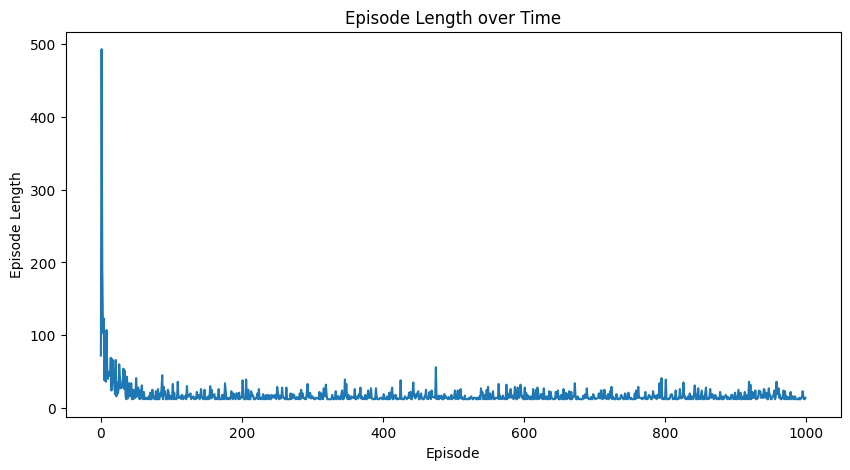

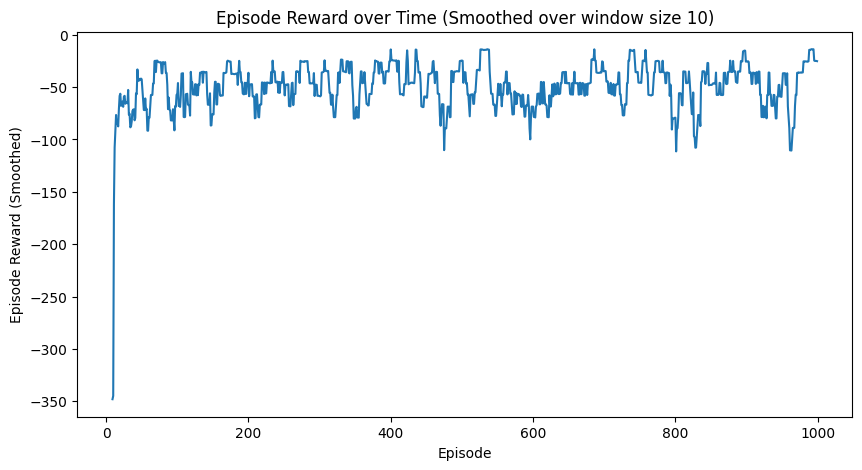

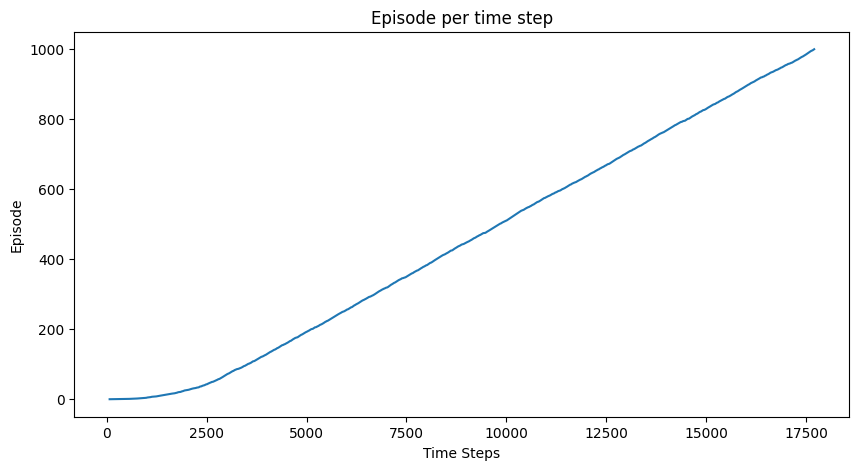

In [7]:
# 顯示訓練結果的圖表(每回合的累積獎勵與步數變化)
# stats是從Q-Learning函式中傳回的紀錄物件，包含訓練過程中的統計數據
# plot_episode_stats是一個繪圖工具函式，會產生三個圖：

# 1.每回合的步數變化(Episode Length over Time)
# 2.每回合總獎勵的滑動平均(Episode Reward over Time (Smoothed over window size 10))
# 3.每個時間步對應的回合數(Episode per time step)

fig = plotting.plot_episode_stats(stats)

In [8]:
# Q是狀態-動作價值函數表(Q-table)，以defaultdict實作，key是狀態(state)，value是該狀態下所有動作的價值陣列
# 範例: Q[36] = [-7.4581, -106.7123, -7.7123, -7.7123]表示狀態36下4個動作的預期回報
# Q值越大表示該動作在該狀態下預期回報越高，策略會傾向選擇Q值最高的動作
Q

defaultdict(<function __main__.q_learning.<locals>.<lambda>()>,
            {36: array([  -7.45813417, -106.71232074,   -7.71232075,   -7.71232075]),
             24: array([-7.71213205, -7.17570464, -7.71232075, -7.45813417]),
             12: array([-7.5698294 , -7.45806016, -7.45805807, -7.57505954]),
             0: array([-7.45450232, -7.36052167, -7.36906676, -7.44746431]),
             1: array([-7.22610427, -7.14915845, -7.25720301, -7.31747811]),
             2: array([-6.997973  , -6.88875562, -7.01203158, -6.92168297]),
             3: array([-6.59438374, -6.61010463, -6.61166469, -6.92772019]),
             4: array([-6.3817308 , -6.31450606, -6.35485379, -6.4134609 ]),
             5: array([-6.02785682, -5.9589565 , -5.92542676, -6.28608725]),
             6: array([-5.84248703, -5.58014583, -5.59053987, -5.78395537]),
             7: array([-5.25158573, -5.14893974, -5.16568781, -5.4852134 ]),
             8: array([-4.86657917, -4.64791629, -4.66020605, -4.64566426]),
 

In [9]:
# 定義一個字典，將動作的編號對應到方向字母(U = 上, R = 右, D = 下, L = 左)
dict1 = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}

# 外層迴圈，遍歷行(row)，這裡假設環境有4行狀態
for row in range(4):
    # 內層迴圈，遍歷列(column)，這裡假設每行有12個狀態
    for column in range(12):
        # 計算該狀態的索引值，假設狀態編號是從0開始到47，排列成4行12列的網格
        state = row * 12 + column

        # 取得該狀態的Q值陣列，找出最大Q值所對應的動作索引(最佳動作)
        best_action = np.argmax(Q[state])

        # 將最佳動作的編號轉成方向字母，並列印出來，後面加空格且不換行
        print(dict1[best_action], ' ', end='')

    # 每輸出完12個狀態後換行，開始輸出下一列
    print()

R  R  R  U  R  D  R  R  L  R  R  D  
D  R  R  R  R  D  R  R  R  D  D  D  
R  R  R  R  R  R  R  R  R  R  R  D  
U  U  U  U  U  U  U  U  U  U  U  U  


In [10]:
# 定義函式play_episodes，讓agent在環境中依照策略執行多回合遊戲並統計結果
# environment：環境物件
# n_episodes：執行的回合數(預設1000)
# policy：依據該策略決定每個狀態下執行的動作機率分布

def play_episodes(environment, n_episodes, policy):
    wins = 0          # 記錄贏得回合數
    total_reward = 0  # 總獲得獎勵累積

    # 執行指定回合數的測試
    for episode in range(n_episodes):
            done = False                       # 回合是否結束的標誌
            state, info = environment.reset()  # 重置環境並取得初始狀態

            # 持續進行直到回合結束
            while not done:
                    # 根據新狀態選擇Q值最高的動作(貪婪選擇)
                    action = np.argmax(policy[state])

                    # 執行選定動作，並取得下一狀態及獎勵
                    next_state, reward, terminated, truncated, info = environment.step(action)

                    # 判斷回合是否結束
                    done = terminated or truncated

                    # 累積本回合總獎勵
                    total_reward += reward

                    # 更新狀態為下一狀態
                    state = next_state

                    # 若回合結束且獲得成功獎勵(-100)，贏次數加一
                    if done and reward > -100:
                            wins += 1

    # 計算每回合平均獎勵
    average_reward = total_reward / n_episodes

    # 傳回贏的次數、總獎勵、平均獎勵
    return wins, total_reward, average_reward

# 測試程式碼：執行1000回合並輸出結果
n_episodes = 1000
wins, total_reward, average_reward = play_episodes(env, n_episodes, Q)
print(f'number of wins over {n_episodes} episodes = {wins}')
print(f'average reward over {n_episodes} episodes = {average_reward} \n\n')

number of wins over 1000 episodes = 1000
average reward over 1000 episodes = -13.0 


